<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Sistema inteligente para ayudar a detectar posibles reclamos (glosas) en las cuentas médicas previo al cobro, de una clínica en Colombia - Audimed</h1></center>
<center><h2>Trabajo Fin de Master<br>Máster Universitario en Análisis y Visualización de Datos Masivos / Visual Analytics and Big Data</h2></center>

<h3>Presentado por: Jacqueline Guzmán Rodriguez</h3>
<h4>Tipo de trabajo: Desarrollo Software <br>
Director: Juan Carlos Rincon Acuña <br>
Fecha: Junio/2024</h4>

<h3> <font color="#040078">Notebook de modelado de los datos</font></h3>
<h4></h4>
<h5><font color="#C62400">Licencia del Notebook CC BY-NC-SA 4.0 DEED <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/" target="_blank]">https://creativecommons.org/licenses/by-nc-sa/4.0/</a></font></h5/>

## Importación de librerias necesarias

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
#from matplotlib import pyplot
#import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
# Read file CSV Download of https://www.kaggle.com/datasets/d8e399cf772f115f4350cae12016ef9f497f63389a06dfdceb3292aa7fb72956
file_cvs = "claims.csv"
# Create dataframe with information of file CSV
df = pd.read_csv(file_cvs, delimiter=',', encoding='utf-8')

In [4]:
# Define colums target (CLAIM)
columns = df.columns
target = "CLAIM"
x_columns = columns.drop(target)

In [5]:
# Update datatype int64 to int32 and float64 to float32, because it is necessary to use less RAM
float_columns = ['QUANTITY_PRODUCT_SERVICE', 'SALES_PRICE', 'INVOICED_PRICE']
int_columns = columns.drop(float_columns)
df[float_columns]=df[float_columns].astype(np.float32)
df[int_columns]=df[int_columns].astype(int)

In [6]:
# Normalize data via MinMaxScaler function
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns=columns)

In [7]:
# Distribution of the target variable
print(str(target)+':\n'+str(df[target].unique())+'\n')
print(df[target].value_counts())

CLAIM:
[0. 1.]

CLAIM
0.0    6104323
1.0        120
Name: count, dtype: int64


In [8]:
# Dividir variables de entrada y objetivo
ValX = df.drop(columns=target)
ValY = df[target]

In [9]:
# Set training and validation data
X_train, X_validation, Y_train, Y_validation = train_test_split(ValX, ValY, test_size=0.15, random_state=1, shuffle=True)

In [10]:
X_train.shape, X_validation.shape

((5188776, 53), (915667, 53))

In [11]:
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
X_train_oversampled, Y_train_oversampled = sm.fit_resample(X_train, Y_train)
df_train_oversampled = pd.concat([pd.DataFrame(Y_train_oversampled), pd.DataFrame(X_train_oversampled)], axis=1)

In [12]:
X_train_oversampled.shape, X_validation.shape

((10377344, 53), (915667, 53))

In [13]:
print(str(target)+':\n'+str(df_train_oversampled[target].unique())+'\n')
print(df_train_oversampled[target].value_counts())

CLAIM:
[0. 1.]

CLAIM
0.0    5188672
1.0    5188672
Name: count, dtype: int64


In [14]:
len(X_train_oversampled.keys())

53

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

insurance_model=tf.keras.Sequential([\
    tf.keras.layers.Dense(53, activation='relu', input_shape=[len(X_train_oversampled.keys())]),\
    tf.keras.layers.Dense(18, activation='relu'),\
    tf.keras.layers.Dense(9, activation='relu'),\
    tf.keras.layers.Dense(3, activation='relu'),\
    tf.keras.layers.Dense(1, activation='sigmoid')\
])
insurance_model.compile(\
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),\
    loss=keras.losses.BinaryCrossentropy(),\
    metrics=METRICS)
insurance_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 53)                2862      
                                                                 
 dense_1 (Dense)             (None, 18)                972       
                                                                 
 dense_2 (Dense)             (None, 9)                 171       
                                                                 
 dense_3 (Dense)             (None, 3)                 30        
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 4039 (15.78 KB)
Trainable params: 4039 (15.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
#feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
model = tf.keras.Sequential([
  layers.Dense(53, activation='relu', input_shape=[len(X_train_oversampled.keys())]),
  layers.Dense(106, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])


In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 53)                2862      
                                                                 
 dense_18 (Dense)            (None, 106)               5724      
                                                                 
 dropout_4 (Dropout)         (None, 106)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 107       
                                                                 
Total params: 8693 (33.96 KB)
Trainable params: 8693 (33.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model.fit(X_train_oversampled,
          Y_train_oversampled,
          epochs=1)

324292/324292 [==============================] - 620s 2ms/step - loss: 0.0049 - accuracy: 0.9989


In [16]:
history=insurance_model.fit(X_train_oversampled,Y_train_oversampled,epochs=1)


324292/324292 [==============================] - 787s 2ms/step - loss: 0.0054 - cross entropy: 0.0054 - Brier score: 0.0011 - tp: 5185844.0000 - fp: 9854.0000 - tn: 5178818.0000 - fn: 2828.0000 - accuracy: 0.9988 - precision: 0.9981 - recall: 0.9995 - auc: 0.9997 - prc: 0.9994


Text(0.5, 0, 'Epochs')

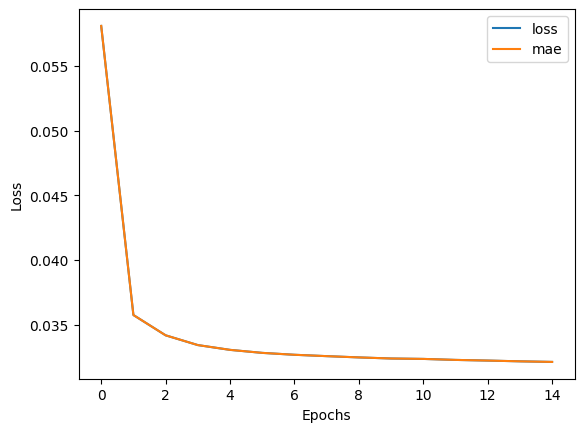

In [25]:
import matplotlib.pyplot as plt
#Graficar la curva de entrenamiento, se ve una tendencia de como el Error Absoluto Medio baja aunque llega a niveles menores de uno, sigue siendo alto para un buen aprendizaje
pd.DataFrame(history.history).plot()
plt.ylabel("Loss")
plt.xlabel("Epochs")

In [26]:
#Evaluación del modelo con los datos de entrenamiento
loss, mae = insurance_model.evaluate(X_train_oversampled, Y_train_oversampled, verbose=2)

324292/324292 - 96s - 297us/step - loss: 0.0291 - mae: 0.0291


In [27]:
#Predicción del modelo
Y_predict = insurance_model.predict(X_validation).flatten()
print(Y_predict)

28615/28615 ━━━━━━━━━━━━━━━━━━━━ 9s 327us/step
[0.00292893 0.00382776 0.00329612 ... 0.00306294 0.00468204 0.00426581]


In [28]:
#Crear un dataset para comprar la salida esperada con la salida de predicción
mlr_diff = pd.DataFrame({'Actual value': Y_validation, 'Predicted value': Y_predict})
mlr_diff.head()

,Actual value,Predicted value
3519216,0.0,0.002929
5421007,0.0,0.003828
1949183,0.0,0.003296
614267,0.0,0.003030
1114087,0.0,0.003251


<Axes: xlabel='Actual value', ylabel='Count'>

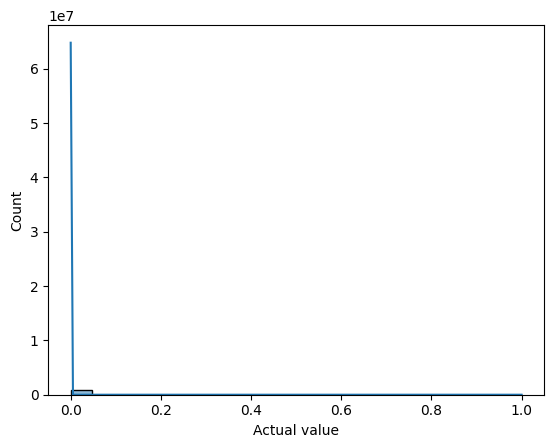

In [29]:
#Comportamiento de la salida esperada
sns.histplot(data=mlr_diff["Actual value"], kde=True)

<Axes: xlabel='Predicted value', ylabel='Count'>

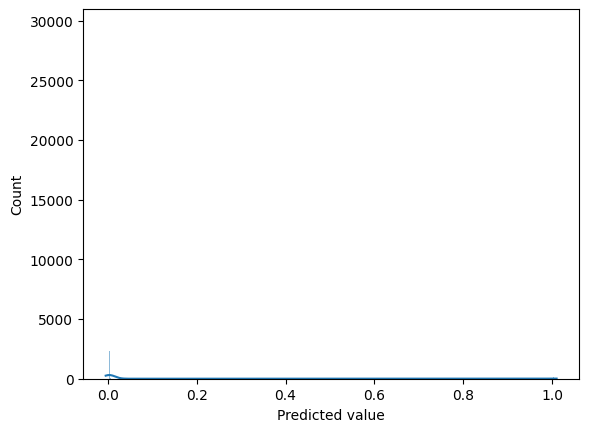

In [30]:
#Comportamiento de la salida predicha 
sns.histplot(data=mlr_diff["Predicted value"], kde=True)

<Axes: ylabel='Count'>

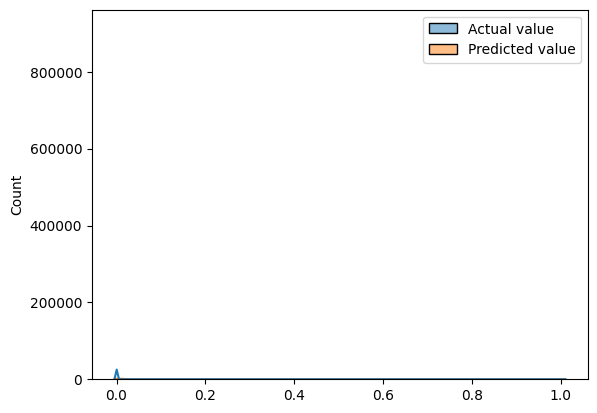

In [31]:
#Comportamiento de la salida esperada y predicha 
sns.histplot(data=mlr_diff, kde=True)